In [1]:
import numpy as np
import pandas as pd

In [2]:
import pandas as pd

df = pd.read_parquet("0000.parquet")
print(df.head())
print("Toplam örnek:", len(df))

                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
1  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
2  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
3  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
4  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
Toplam örnek: 33984


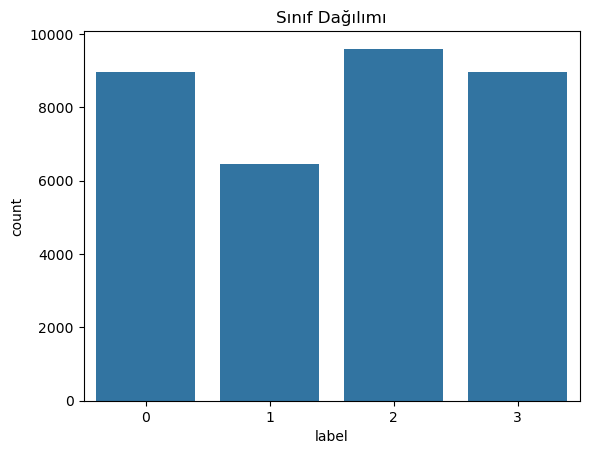

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=df)
plt.title("Sınıf Dağılımı")
plt.show()

In [5]:
df.describe()

,label
count,33984.000000
mean,1.546139
std,1.141281
min,0.000000
25%,0.000000
50%,2.000000
75%,3.000000
max,3.000000


In [7]:
df.isnull().sum()

image    0
label    0
dtype: int64

In [8]:
df.shape

(33984, 2)

In [13]:
np.unique(df['label'])

array([0, 1, 2, 3], dtype=int64)

In [23]:
X = np.stack(df['image'].values)  # shape: (num_samples, 128, 128)
y = df['label'].values            # shape: (num_samples,)

In [27]:
sample = df['image'].iloc[0]
print(type(sample))
print(sample.keys())  # Eğer dict ise

<class 'dict'>
dict_keys(['bytes', 'path'])


In [29]:
from PIL import Image
import io
import numpy as np

def decode_image(image_dict):
    byte_data = image_dict['bytes']
    image = Image.open(io.BytesIO(byte_data)).convert('L')  # 'L' → grayscale
    image = image.resize((128, 128))  # boyut sabitleme (isteğe bağlı)
    return np.array(image)

# Tüm görüntüleri decode et
X = np.array([decode_image(img_dict) for img_dict in df['image']])

In [30]:
X = X[..., np.newaxis]               # shape: (num_samples, 128, 128, 1)
X = X.astype('float32') / 255.0      # normalize

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df['label']
)

In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

input_shape = (128, 128, 1)
num_classes = 4

inputs = Input(shape=input_shape)

x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', name='last_conv')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ last_conv (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,476 (12.61 MB)

 Trainable params: 3,305,028 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [45]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)

In [49]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

# Eğitim erken durdurma (overfitting'e karşı)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 384s 449ms/step - accuracy: 0.4162 - loss: 1.3347 - val_accuracy: 0.6818 - val_loss: 0.7478
Epoch 2/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 350s 412ms/step - accuracy: 0.6128 - loss: 0.8147 - val_accuracy: 0.7667 - val_loss: 0.5607
Epoch 3/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 351s 413ms/step - accuracy: 0.6907 - loss: 0.6646 - val_accuracy: 0.7968 - val_loss: 0.4856
Epoch 4/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 347s 408ms/step - accuracy: 0.7292 - loss: 0.5799 - val_accuracy: 0.8239 - val_loss: 0.4112
Epoch 5/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 344s 405ms/step - accuracy: 0.7716 - loss: 0.4943 - val_accuracy: 0.8532 - val_loss: 0.3674
Epoch 6/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 343s 403ms/step - accuracy: 0.7982 - loss: 0.4285 - val_accuracy: 0.8694 - val_loss: 0.3210
Epoch 7/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 344s 405ms/step - accuracy: 0.8270 - loss: 0.3741 - val_accuracy: 0.8738 - val_loss: 0.3046
Epoch 8/50
850/850 ━━━━━━━━━━━━━━━━━━━━ 344s 405ms/step - accuracy: 0.8457 -

In [53]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print(classification_report(y_true_classes, y_pred_classes))

213/213 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1792
           1       0.98      1.00      0.99      1293
           2       0.89      0.91      0.90      1920
           3       0.89      0.83      0.85      1792

    accuracy                           0.91      6797
   macro avg       0.91      0.91      0.91      6797
weighted avg       0.91      0.91      0.91      6797



In [57]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_gradcam(model, image, class_index, layer_name=None):
    # Giriş görüntüsünü batch haline getir
    image = np.expand_dims(image, axis=0)

    # Eğer layer_name verilmediyse son Conv2D katmanını bul
    if layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                layer_name = layer.name
                break

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)

    # Gradientlerin ortalamasını al
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1).numpy()[0]

    # Normalize et
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)
    cam = cv2.resize(cam, (image.shape[2], image.shape[1]))

    return cam

C:\Users\seyid\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_14']
Received: inputs=Tensor(shape=(1, 128, 128, 1))
  warnings.warn(msg)


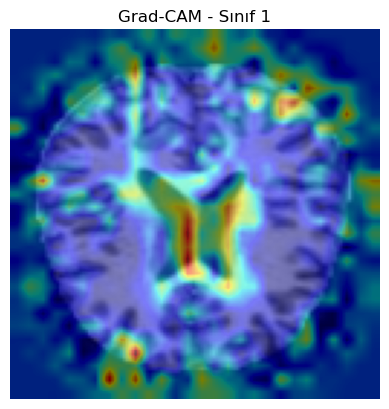

In [59]:
cam = generate_gradcam(model, X_val[0], class_index=1)
plt.imshow(X_val[0], cmap='gray')
plt.imshow(cam, cmap='jet', alpha=0.5)
plt.title("Grad-CAM - Sınıf 1")
plt.axis('off')
plt.show()

In [61]:
model.save("mri_classifier_gradcam.h5")

In [63]:
model.save("mri_classifier_gradcam.keras")

In [65]:
from sklearn.metrics import classification_report
import numpy as np

# Tahminleri al
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# Raporu yazdır
print(classification_report(y_true_classes, y_pred_classes, digits=4))

213/213 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step
              precision    recall  f1-score   support

           0     0.8928    0.9202    0.9063      1792
           1     0.9825    0.9985    0.9904      1293
           2     0.8862    0.9083    0.8971      1920
           3     0.8867    0.8253    0.8549      1792

    accuracy                         0.9067      6797
   macro avg     0.9120    0.9131    0.9122      6797
weighted avg     0.9064    0.9067    0.9062      6797



C:\Users\seyid\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_14']
Received: inputs=Tensor(shape=(1, 128, 128, 1))
  warnings.warn(msg)


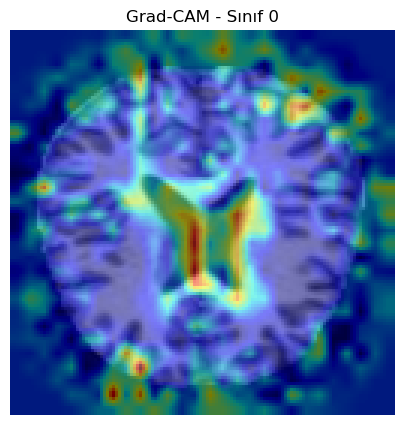

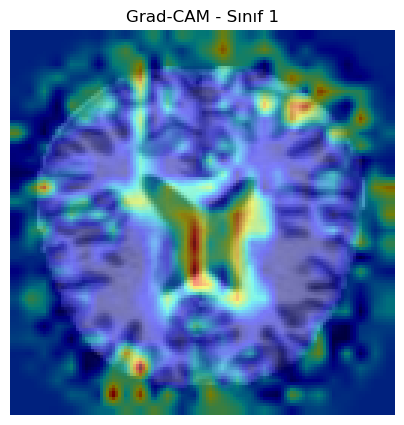

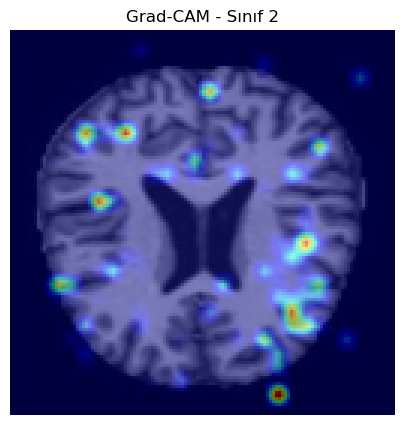

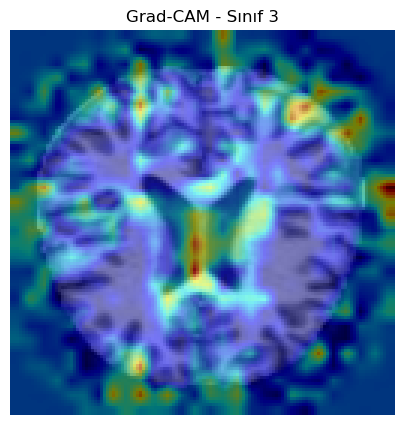

In [67]:
sample_index = 0  # Görselleştirmek istediğin örnek
num_classes = model.output_shape[-1]

for class_idx in range(num_classes):
    cam = generate_gradcam(model, X_val[sample_index], class_index=class_idx)
    plt.figure(figsize=(5, 5))
    plt.imshow(X_val[sample_index], cmap='gray')
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f"Grad-CAM - Sınıf {class_idx}")
    plt.axis('off')
    plt.show()